# chaotic attractor reconstruction
A system can be described by a vector of real numbers, called its state, that aims to provide a complete description of the system at some point in time. The set of all possible states is the system’s phase space or state space. This space and a rule specifying its evolution over time defines a dynamical system. These rules often take the form of differential equations.

An ordered set of state values over time is called a trajectory. Depending on the system, different trajectories can evolve to a common subset of phase space called an attractor. The presence and behavior of attractors gives intuition about the underlying dynamical system. We can visualize the system and its attractors by plotting the trajectory of many different initial state values and numerically integrating them to approximate their continuous time evolution on discrete computers. For dynamical systems with more than 3 coordinates, the state space can be partially visualized by mapping a subset of its coordinates to the x, y, and z axes.

Consider the Lorenz attractor, defined by the following differential equations:

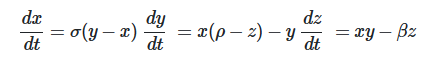

A common set of initial conditions is x=−8.0, y=8.0, z=27.0
 with parameters σ=10, $ρ=\frac 8 3 $, β=28
. When integrated using these values, a butterfly-like attractor is revealed. This is an example of a chaotic attractor, defined by aperiodic trajectories that diverge exponentially fast.

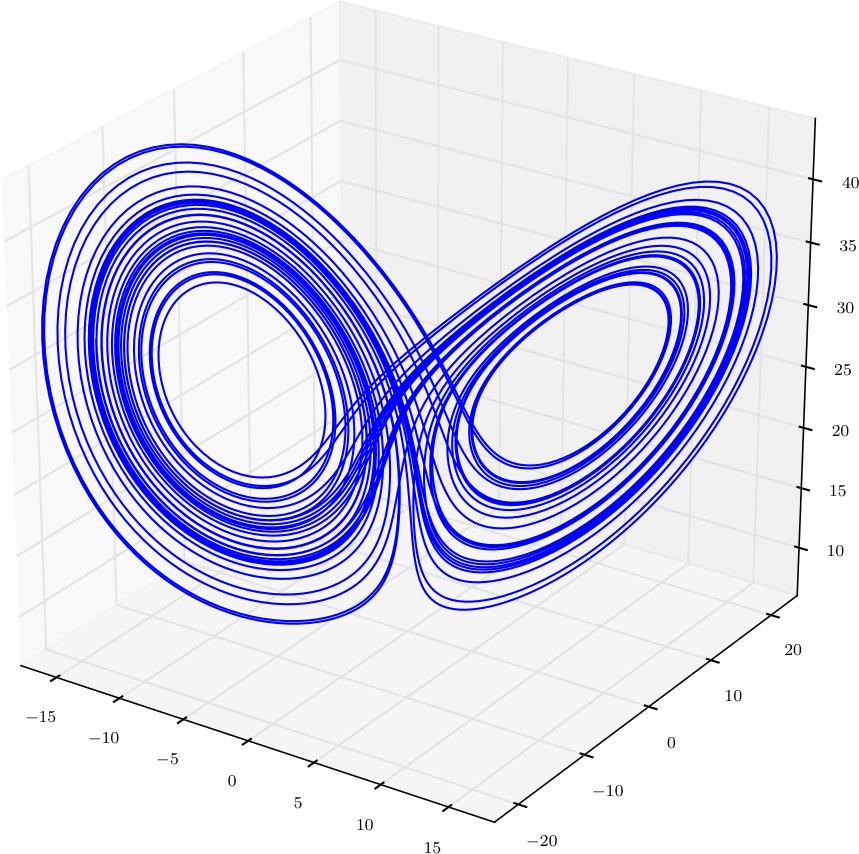

Of course, dynamical systems and chaos theory are entire fields of study that cannot be adequately summarized here. Our purpose is to demonstrate the reconstruction of chaotic attractors from incomplete system measurements: for example, a time series from only the first of the Lorenz equations. Takens’ Embedding Theorem explains how the phase space of an attractor can be reconstructed using time-delayed measurements of a single variable. These ideas will further be explored using the information theory functions found in the Computational Mechanics in Python (CMPy) package.


In [10]:

import numpy

#import pylab as pl   注释
import matplotlib.pyplot as plt  #添加

%matplotlib inline

# Init parameters for lorenz
# x = -8.0
# y = 8.0
# z = 27.0
# sigma = 10
# rho = 8/3
# beta = 28

# generating a time series.

We first need a framework for generating trajectories from dynamical systems with different numbers of equations and parameters. Fortunately, Python makes this relatively straightforward. Consider the following code to generate a trajectory given a set of ODEs:

In [2]:
def generate(data_length, odes, state, parameters):
    data = numpy.zeros([state.shape[0], data_length])

    for i in range(5000):
        state = rk4(odes, state, parameters)

    for i in range(data_length):
        state = rk4(odes, state, parameters)
        data[:, i] = state

    return data

This function allocates and fills a Numpy array with data_length measurements of a system’s state over time, resulting from the numerical integration of the ODEs. The first 5000 iterates are regarded as transient and discarded: this number is a guess and may be increased, decreased, or removed altogether if desired.

The details of numerical integration are outside the scope of this tutorial, but the basic idea is this: we need a way to obtain the next state of a dynamical system given its current state and its ODEs. Since we are dealing with continuous time equations using a discrete computer, we can approximate the solution of these ODEs by integrating over a discrete time step. Smaller steps trade increased computation for greater accuracy. In addition to the step size dt, the integration technique also affects accuracy. The simplest method for integration is the Euler method. In the above code the rk4 function is a fourth-order Runge-Kutta integrator, balancing accuracy and computation by averaging over a set of predictors:

In [3]:
def rk4(odes, state, parameters, dt=0.01):
    k1 = dt * odes(state, parameters)
    k2 = dt * odes(state + 0.5 * k1, parameters)
    k3 = dt * odes(state + 0.5 * k2, parameters)
    k4 = dt * odes(state + k3, parameters)
    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

Finally, we define the Lorenz equations and tie everything together with a helper function lorenz_generate that passes a typical set of initial state and parameter values to generate:

In [4]:
# def lorenz_odes((x, y, z), (sigma, beta, rho)):
#     return numpy.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

# Python 3.9 下作了修改
def lorenz_odes(a,b):
    x = a[0]
    y = a[1]
    z = a[2]
    sigma = b[0]
    beta = b[1]
    rho = b[2]
    return numpy.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

def lorenz_generate(data_length):
    return generate(data_length, lorenz_odes, \
        numpy.array([-8.0, 8.0, 27.0]), numpy.array([10.0, 8/3.0, 28.0]))


# We also define the Rössler equations:

# def rossler_odes((x, y, z), (a, b, c)):
#     return numpy.array([-y - z, x + a * y, b + z * (x - c)])    

# Python 3.9 下作了修改
def rossler_odes(para1, para2):
    x = para1[0]
    y = para1[1]
    z = para1[2]
    a = para2[0]
    b = para2[1]
    c = para2[2]
    return numpy.array([-y - z, x + a * y, b + z * (x - c)])


def rossler_generate(data_length):
    return generate(data_length, rossler_odes, \
        numpy.array([10.0, 0.0, 0.0]), numpy.array([0.15, 0.2, 10.0]))

A time series from the first Lorenz equation is simple to plot:

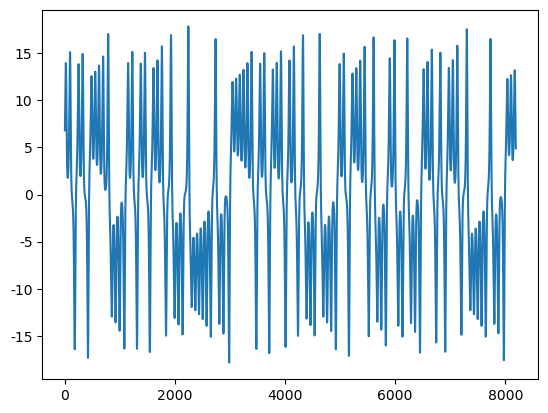

In [11]:
data = lorenz_generate(2**13)
plt.plot(data[0])


The Lorenz attractor was shown earlier; the code is below and uses Matplotlib’s experimental 3D plotting.

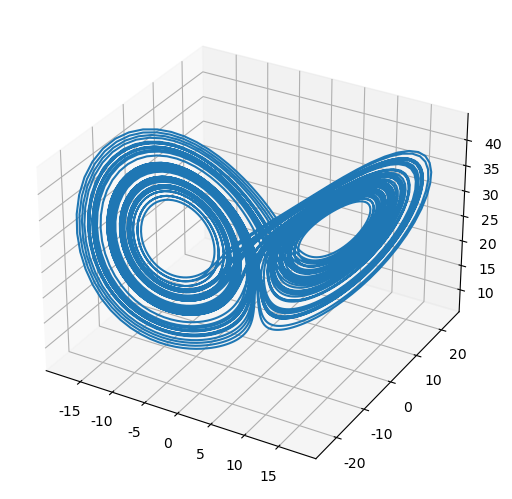

In [14]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

figure = plt.figure()
axes = Axes3D(figure)
axes.plot3D(data[0], data[1], data[2])
figure.add_axes(axes)
plt.show()

# time delay embedding.

Delaying the time series produced by a single ODE creates a higher dimensional embedding and, by Takens’ Embedding Theorem, allows the phase space of the attractor to be reconstructed. If the measurement variable at time t  is defined by x(t) , an (n+1)-dimensional embedding is defined by:

$ [x(t),x(t+τ),…,x(t+nτ)] $

The choice of τ  determines the accuracy of the reconstructed attractor. Too small a value will plot the attractor along a line and too large a value will not reveal the structure of the attractor (see this page for examples). Fraser and Swinney suggest using the first local minimum of the mutual information between the delayed and non-delayed time series, effectively identifying a value of τ  for which they share the least information. (In the general case we may also need to identify the attractor’s phase space dimension — we ignore this problem here.)

The code below generates data from a dynamical system, discretizes the values into equal frequency bins, and then measures the mutual information I  for increasing values of τ
 up to some maximum value. The numpy function roll performs the delay by shifting all values over to the left by τ. The series must then be shortened by τ values since our data is of fixed length and there are no additional values to shift in. The loop terminates early if the current I is larger than the previous I, indicating we’ve found the first local minimum. We then embed this time series into 3 dimensions using the corresponding value of τ.


In [16]:
# create time series
data = lorenz_generate(2**14)[0]
data = preprocess(data, quantize_cols=[0], quantize_bins=1000)

# find usable time delay via mutual information
tau_max = 100
mis = []

for tau in range(1, tau_max):
    unlagged = data[:-tau]
    lagged = numpy.roll(data, -tau)[:-tau]
    joint = numpy.hstack((unlagged, lagged))
    mis.append(mutual_information(joint, normalized=True))

    if len(mis) > 1 and mis[-2] < mis[-1]: # return first local minima
        tau -= 1
        print(tau, mis)
        break

# plot time delay embedding
figure = pylab.figure()
axes = Axes3D(figure)
data_lag0 = data[:-2].flatten()
data_lag1 = numpy.roll(data, -tau)[:-2].flatten()
data_lag2 = numpy.roll(data, -2 * tau)[:-2].flatten()
axes.plot3D(data_lag0, data_lag1, data_lag2)
figure.add_axes(axes)

plt.show()

NameError: name 'preprocess' is not defined

In [ ]:
import 

parser.py lorenz